# MACD

在MACD_3的基础上加入仓位风险控制模块，提高收益稳定性。最终实现Sharpe Ratio：？，总收益率：？，百分比最大回撤: ？

## 配置引擎参数

In [1]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 00:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181127 23:59') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [2]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MACDStrategy(CtaTemplate):
    """MACD策略"""
    className = 'MACDStrategy'
    author = 'xiaotao'
    
    # 策略参数
    fastPeriod = 12     # 收盘价快速均线参数
    slowPeriod = 26    # 收盘价慢速均线参数
    M = 9
    lot = 100             # 设置手数
        
    fastPeriod_v = 2    #成交量快速均线参数
    slowPeriod_v = 4    #成交量慢速均线参数
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am60.close, self.fastPeriod)
        slowMa = ta.EMA(am60.close, self.slowPeriod)
        diff = fastMa - slowMa
        dea = ta.EMA(diff,self.M)
        MACD = 2*(diff - dea)
        diff_MACD_1 = (MACD[-1]-MACD[-2])/MACD[-2]
        diff_MACD_2 = (MACD[-5]-MACD[-6])/MACD[-6]
        
        fastMa_v = ta.EMA(am60.volume, self.fastPeriod_v)
        slowMa_v = ta.EMA(am60.volume, self.slowPeriod_v)
        
        crossOver = (diff[-1]>0) and (diff_MACD_1>0.2) and (diff_MACD_2>0.1) and (fastMa_v[-1]>slowMa_v[-1]) and (fastMa_v[-2]>slowMa_v[-2])
        crossBelow = (diff[-1]<0) and (diff_MACD_1<-0.25) and (fastMa_v[-1]<slowMa_v[-1]) and (fastMa_v[-2]<slowMa_v[-2])

        
        # 构建进出场逻辑-------------------------------------------------
        # 如果金叉时手头没有多头持仓
        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 如果金叉时手头没有空头持仓
        elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [3]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(MACDStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDStrategy.on60MinBar at 0x0000026A7018B510>, <__main__.MACDStrategy object at 0x0000026A7018A588>)
2018-12-20 20:06:45.946133	开始回测
2018-12-20 20:06:45.946133	策略初始化
2018-12-20 20:06:45.947130	载入历史数据。数据范围:[20180523 16:00,20180601 00:00)
2018-12-20 20:06:47.712410	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-20 20:06:47.714404	载入完成，数据量：12000
2018-12-20 20:06:47.714404	策略初始化完成
2018-12-20 20:06:47.714404	策略启动完成
2018-12-20 20:06:47.714404	开始回放回测数据,回测范围:[20180601 00:00,20181127 23:59)
2018-12-20 20:06:47.736386	载入历史数据。数据范围:[20180601 00:00,20181127 23:59)
2018-12-20 20:07:00.175271	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-20 20:07:00.242096	载入完成，数据量：257407
2018-12-20 20:07:00.243088	当前回放数据:[20180601 00:00,20181127 23:59)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601000000
2018-12-20 20:07:00.244086	载入历史数据。数据范围:[20180531 08:51,20180603 00:01

In [4]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-06-05 04:00:00,空,,,0.0,,开仓,1,,7494.99,0.0,None,,,1,2018-06-05 04:00:00,100,1,BTCUSDT:binance,1
2018-06-26 22:00:00,多,,,0.0,,平仓,2,,6170.03,0.0,None,,,2,2018-06-26 22:00:00,100,2,BTCUSDT:binance,2
2018-06-26 22:00:00,多,,,0.0,,开仓,3,,6170.03,0.0,None,,,3,2018-06-26 22:00:00,100,3,BTCUSDT:binance,3
2018-06-28 16:00:00,空,,,0.0,,平仓,4,,6116.75,0.0,None,,,4,2018-06-28 16:00:00,100,4,BTCUSDT:binance,4
2018-06-28 16:00:00,空,,,0.0,,开仓,5,,6116.75,0.0,None,,,5,2018-06-28 16:00:00,100,5,BTCUSDT:binance,5
2018-06-30 10:00:00,多,,,0.0,,平仓,6,,6411.99,0.0,None,,,6,2018-06-30 10:00:00,100,6,BTCUSDT:binance,6
2018-06-30 10:00:00,多,,,0.0,,开仓,7,,6411.99,0.0,None,,,7,2018-06-30 10:00:00,100,7,BTCUSDT:binance,7
2018-07-06 09:00:00,空,,,0.0,,平仓,8,,6531.00,0.0,None,,,8,2018-07-06 09:00:00,100,8,BTCUSDT:binance,8
2018-07-06 09:00:00,空,,,0.0,,开仓,9,,6531.00,0.0,None,,,9,2018-07-06 09:00:00,100,9,BTCUSDT:binance,9


## 查看绩效回测绩效

2018-12-20 20:07:16.985271	计算按日统计结果
2018-12-20 20:07:17.031148	------------------------------
2018-12-20 20:07:17.031148	首个交易日：	2018-06-01 00:00:00
2018-12-20 20:07:17.031148	最后交易日：	2018-11-27 00:00:00
2018-12-20 20:07:17.031148	总交易日：	180
2018-12-20 20:07:17.031148	盈利交易日	107
2018-12-20 20:07:17.031148	亏损交易日：	68
2018-12-20 20:07:17.031148	起始资金：	1000000
2018-12-20 20:07:17.032145	结束资金：	1,690,056.63
2018-12-20 20:07:17.032145	总收益率：	69.01%
2018-12-20 20:07:17.032145	年化收益：	92.01%
2018-12-20 20:07:17.032145	总盈亏：	690,056.63
2018-12-20 20:07:17.032145	最大回撤: 	-86,565.08
2018-12-20 20:07:17.032145	百分比最大回撤: -7.38%
2018-12-20 20:07:17.032145	总手续费：	23,038.57
2018-12-20 20:07:17.032145	总滑点：	13.8
2018-12-20 20:07:17.032145	总成交金额：	46,077,139.0
2018-12-20 20:07:17.033143	总成交笔数：	69
2018-12-20 20:07:17.033143	日均盈亏：	3,833.65
2018-12-20 20:07:17.033143	日均手续费：	127.99
2018-12-20 20:07:17.033143	日均滑点：	0.08
2018-12-20 20:07:17.033143	日均成交金额：	255,984.11
2018-12-20 20:07:17.033143	日均成交笔数：	0.38
2018-12-20 20:07:1

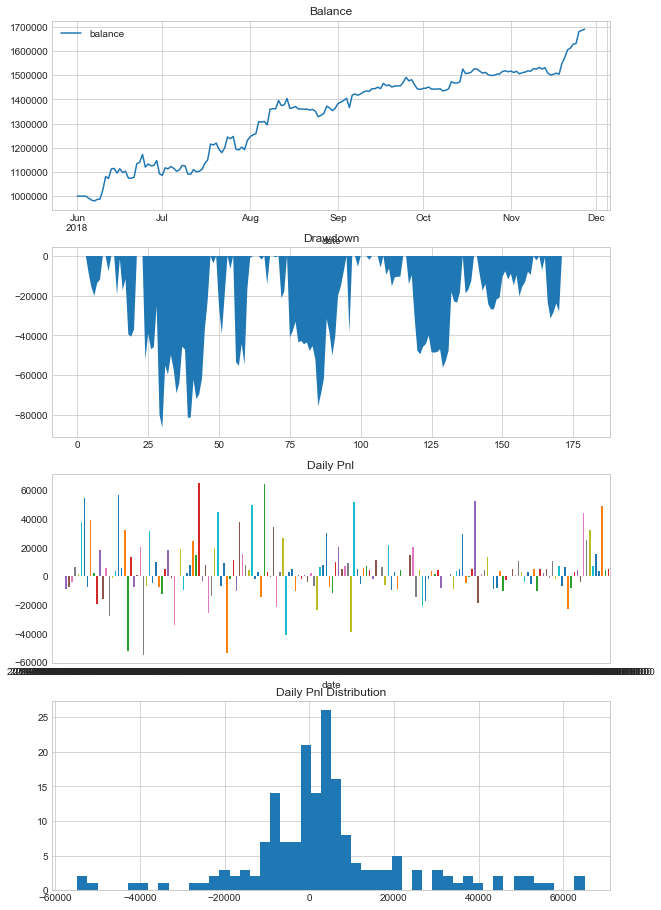

In [5]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-19 22:30:29.038841	计算回测结果
2018-12-19 22:30:29.042831	------------------------------
2018-12-19 22:30:29.042831	第一笔交易：	2018-06-26 22:00:00
2018-12-19 22:30:29.042831	最后一笔交易：	2018-11-27 23:57:00
2018-12-19 22:30:29.042831	总交易次数：	35
2018-12-19 22:30:29.042831	总盈亏：	689,867.38
2018-12-19 22:30:29.042831	最大回撤: 	-50,998.31
2018-12-19 22:30:29.043827	平均每笔盈利：	19,710.5
2018-12-19 22:30:29.043827	平均每笔滑点：	0.4
2018-12-19 22:30:29.043827	平均每笔佣金：	663.65
2018-12-19 22:30:29.043827	胜率		54.29%
2018-12-19 22:30:29.043827	盈利交易平均值	48,899.75
2018-12-19 22:30:29.043827	亏损交易平均值	-14,951.75
2018-12-19 22:30:29.043827	盈亏比：	3.27


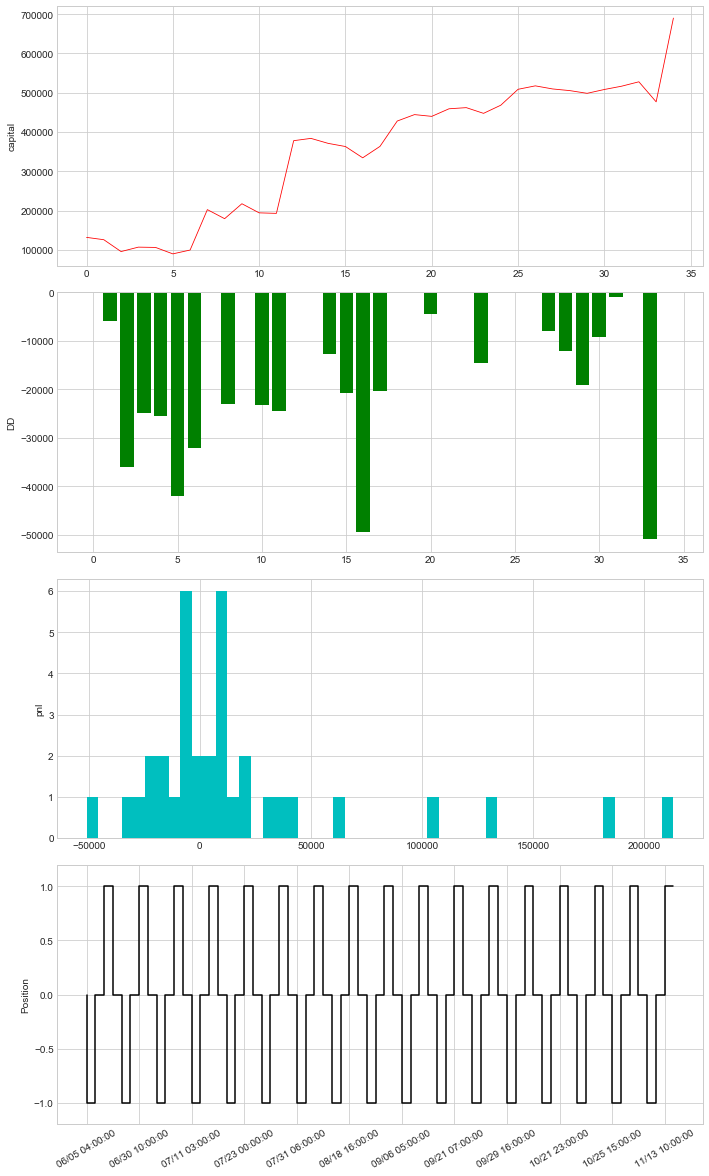

In [175]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [6]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2018-12-20 20:07:19.326012	计算按日统计结果


In [7]:
print(pd.Series(result)) # 显示绩效指标

startDate           2018-06-01 00:00:00
endDate             2018-11-27 00:00:00
totalDays                           180
profitDays                          107
lossDays                             68
endBalance                  1.69006e+06
maxDrawdown                    -86565.1
maxDdPercent                   -7.38344
totalNetPnl                      690057
dailyNetPnl                     3833.65
totalCommission                 23038.6
dailyCommission                 127.992
totalSlippage                      13.8
dailySlippage                 0.0766667
totalTurnover               4.60771e+07
dailyTurnover                    255984
totalTradeCount                      69
dailyTradeCount                0.383333
totalReturn                     69.0057
annualizedReturn                92.0076
dailyReturn                    0.291534
returnStd                       1.53516
sharpeRatio                     2.94199
dtype: object


#下面对EOS品种进行检测
对策略做了参数调整：
1）手数改为10000
2）diff_MACD_2的周期，还有阈值。

In [8]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180611 00:00',initHours=20) # 设置回测用的数据起始日期
engine.setEndDate('20181127 23:59') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [9]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MACDStrategy(CtaTemplate):
    """MACD策略"""
    className = 'MACDStrategy'
    author = 'xiaotao'
    
    # 策略参数
    fastPeriod = 12     # 收盘价快速均线参数
    slowPeriod = 26    # 收盘价慢速均线参数
    M = 9
    lot = 10000             # 设置手数
        
    fastPeriod_v = 2    #成交量快速均线参数
    slowPeriod_v = 4    #成交量慢速均线参数
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am60.close, self.fastPeriod)
        slowMa = ta.EMA(am60.close, self.slowPeriod)
        diff = fastMa - slowMa
        dea = ta.EMA(diff,self.M)
        MACD = 2*(diff - dea)
        diff_MACD_1 = (MACD[-1]-MACD[-2])/MACD[-2]
        diff_MACD_2 = (MACD[-3]-MACD[-4])/MACD[-4]
        
        fastMa_v = ta.EMA(am60.volume, self.fastPeriod_v)
        slowMa_v = ta.EMA(am60.volume, self.slowPeriod_v)
        
        crossOver = (diff[-1]>0) and (diff_MACD_1>0.12) and (diff_MACD_2>0) and (fastMa_v[-1]>slowMa_v[-1]) and (fastMa_v[-2]>slowMa_v[-2])
        crossBelow = (diff[-1]<0) and (diff_MACD_1<-0.12) and (diff_MACD_2<0) and (fastMa_v[-1]<slowMa_v[-1]) and (fastMa_v[-2]<slowMa_v[-2])

        
        # 构建进出场逻辑-------------------------------------------------
        # 如果金叉时手头没有多头持仓
        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 如果金叉时手头没有空头持仓
        elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [10]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
engine.initStrategy(MACDStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDStrategy.on60MinBar at 0x0000026A02D03730>, <__main__.MACDStrategy object at 0x0000026A01EB1048>)
2018-12-20 20:07:19.485586	开始回测
2018-12-20 20:07:19.485586	策略初始化
2018-12-20 20:07:19.485586	载入历史数据。数据范围:[20180610 04:00,20180611 00:00)
2018-12-20 20:07:19.551411	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-20 20:07:19.551411	载入完成，数据量：1200
2018-12-20 20:07:19.552408	策略初始化完成
2018-12-20 20:07:19.552408	策略启动完成
2018-12-20 20:07:19.552408	开始回放回测数据,回测范围:[20180611 00:00,20181127 23:59)
2018-12-20 20:07:19.569363	载入历史数据。数据范围:[20180611 00:00,20181127 23:59)
2018-12-20 20:07:30.299973	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-20 20:07:30.363826	载入完成，数据量：243007
2018-12-20 20:07:30.364799	当前回放数据:[20180611 00:00,20181127 23:59)
[INFO] 品种EOSUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180611000000
2018-12-20 20:07:30.366794	载入历史数据。数据范围:[20180610 08:51,20180613 00:01)

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606200000 , 20180610230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180611000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180611000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.15, 'high': 13.1647, 'low': 12.922, 'close': 12.9499, 'date': '20180611', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 11, 0, 0), 'volume': 385852.4499999997, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606210000 , 20180611000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180611000000
2018-12-20 20:07:42.023242	数据回放结束ss: 100%    


In [11]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-06-11 10:00:00,空,,,0.0,,开仓,1,,11.4065,0.0,None,,,1,2018-06-11 10:00:00,10000,1,EOSUSDT:binance,1
2018-06-19 02:00:00,多,,,0.0,,平仓,2,,10.6808,0.0,None,,,2,2018-06-19 02:00:00,10000,2,EOSUSDT:binance,2
2018-06-19 02:00:00,多,,,0.0,,开仓,3,,10.6808,0.0,None,,,3,2018-06-19 02:00:00,10000,3,EOSUSDT:binance,3
2018-06-21 07:00:00,空,,,0.0,,平仓,4,,10.4072,0.0,None,,,4,2018-06-21 07:00:00,10000,4,EOSUSDT:binance,4
2018-06-21 07:00:00,空,,,0.0,,开仓,5,,10.4072,0.0,None,,,5,2018-06-21 07:00:00,10000,5,EOSUSDT:binance,5
2018-06-21 12:00:00,多,,,0.0,,平仓,6,,10.6779,0.0,None,,,6,2018-06-21 12:00:00,10000,6,EOSUSDT:binance,6
2018-06-21 12:00:00,多,,,0.0,,开仓,7,,10.6779,0.0,None,,,7,2018-06-21 12:00:00,10000,7,EOSUSDT:binance,7
2018-06-22 09:00:00,空,,,0.0,,平仓,8,,10.3916,0.0,None,,,8,2018-06-22 09:00:00,10000,8,EOSUSDT:binance,8
2018-06-22 09:00:00,空,,,0.0,,开仓,9,,10.3916,0.0,None,,,9,2018-06-22 09:00:00,10000,9,EOSUSDT:binance,9


2018-12-20 20:07:42.091030	计算按日统计结果
2018-12-20 20:07:42.124338	------------------------------
2018-12-20 20:07:42.124338	首个交易日：	2018-06-11 00:00:00
2018-12-20 20:07:42.124338	最后交易日：	2018-11-27 00:00:00
2018-12-20 20:07:42.124338	总交易日：	170
2018-12-20 20:07:42.124338	盈利交易日	94
2018-12-20 20:07:42.124338	亏损交易日：	76
2018-12-20 20:07:42.124338	起始资金：	1000000
2018-12-20 20:07:42.124338	结束资金：	1,130,828.56
2018-12-20 20:07:42.125336	总收益率：	13.08%
2018-12-20 20:07:42.125336	年化收益：	18.47%
2018-12-20 20:07:42.125336	总盈亏：	130,828.56
2018-12-20 20:07:42.126333	最大回撤: 	-19,402.66
2018-12-20 20:07:42.126333	百分比最大回撤: -1.91%
2018-12-20 20:07:42.126333	总手续费：	3,333.44
2018-12-20 20:07:42.126333	总滑点：	2,020.0
2018-12-20 20:07:42.126333	总成交金额：	6,666,871.0
2018-12-20 20:07:42.127330	总成交笔数：	101
2018-12-20 20:07:42.127330	日均盈亏：	769.58
2018-12-20 20:07:42.127330	日均手续费：	19.61
2018-12-20 20:07:42.128328	日均滑点：	11.88
2018-12-20 20:07:42.128328	日均成交金额：	39,216.89
2018-12-20 20:07:42.128328	日均成交笔数：	0.59
2018-12-20 20:07:42.

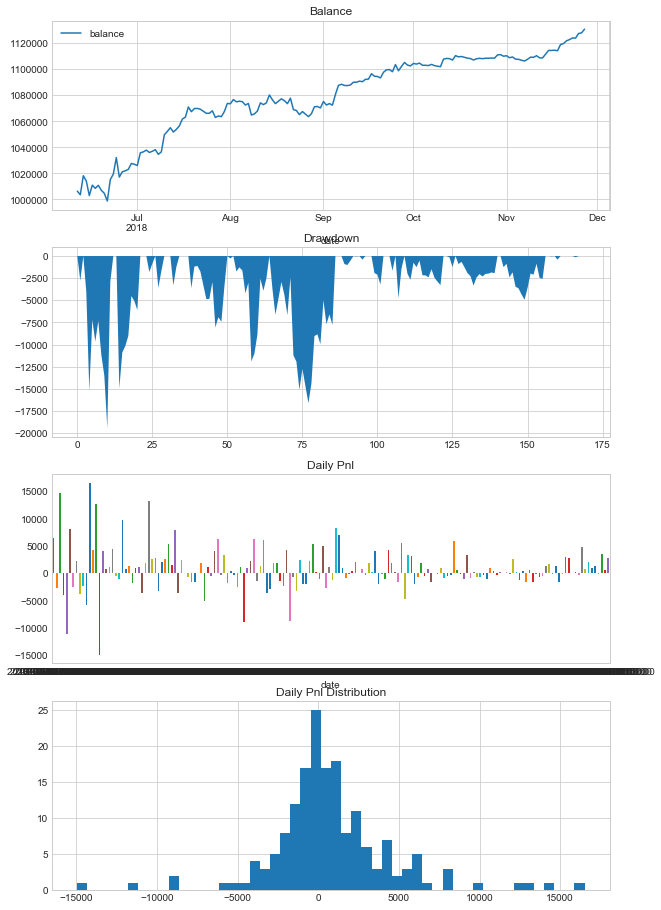

In [12]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-20 20:07:44.152915	计算回测结果
2018-12-20 20:07:44.157902	------------------------------
2018-12-20 20:07:44.157902	第一笔交易：	2018-06-19 02:00:00
2018-12-20 20:07:44.157902	最后一笔交易：	2018-11-27 23:57:00
2018-12-20 20:07:44.157902	总交易次数：	51
2018-12-20 20:07:44.157902	总盈亏：	130,793.77
2018-12-20 20:07:44.157902	最大回撤: 	-14,417.5
2018-12-20 20:07:44.157902	平均每笔盈利：	2,564.58
2018-12-20 20:07:44.157902	平均每笔滑点：	40.0
2018-12-20 20:07:44.157902	平均每笔佣金：	65.65
2018-12-20 20:07:44.157902	胜率		52.94%
2018-12-20 20:07:44.157902	盈利交易平均值	6,752.08
2018-12-20 20:07:44.157902	亏损交易平均值	-2,146.35
2018-12-20 20:07:44.157902	盈亏比：	3.15


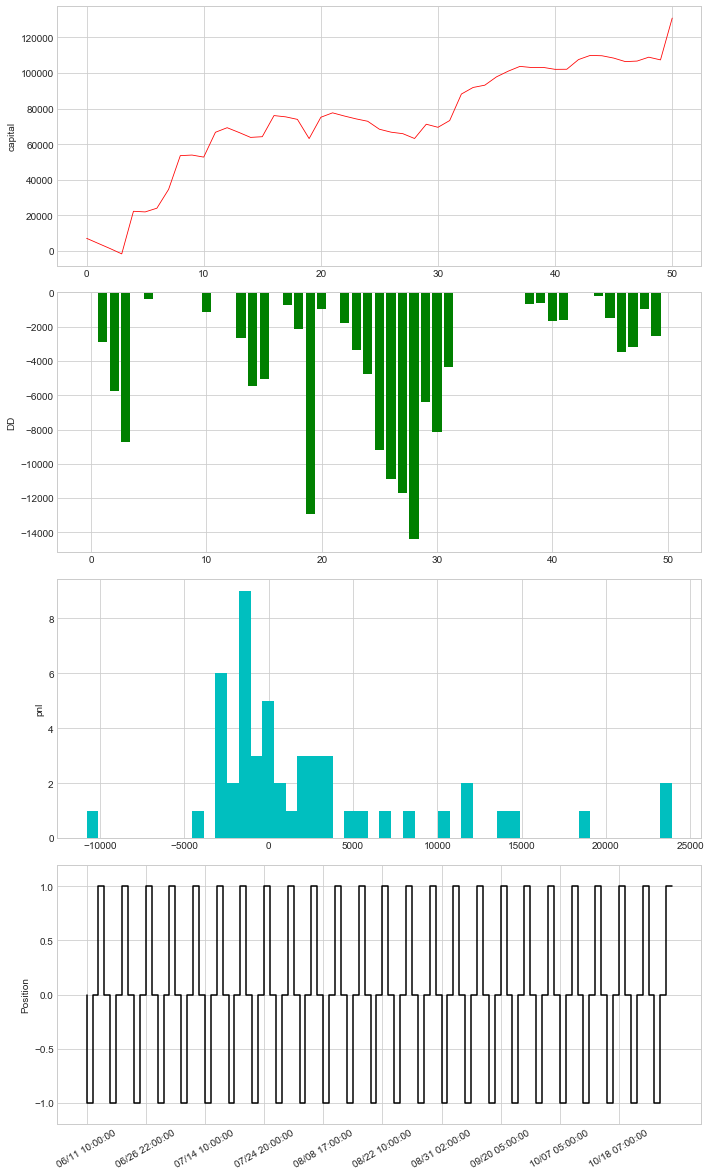

In [13]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [14]:
print(pd.Series(result)) # 显示绩效指标

startDate           2018-06-01 00:00:00
endDate             2018-11-27 00:00:00
totalDays                           180
profitDays                          107
lossDays                             68
endBalance                  1.69006e+06
maxDrawdown                    -86565.1
maxDdPercent                   -7.38344
totalNetPnl                      690057
dailyNetPnl                     3833.65
totalCommission                 23038.6
dailyCommission                 127.992
totalSlippage                      13.8
dailySlippage                 0.0766667
totalTurnover               4.60771e+07
dailyTurnover                    255984
totalTradeCount                      69
dailyTradeCount                0.383333
totalReturn                     69.0057
annualizedReturn                92.0076
dailyReturn                    0.291534
returnStd                       1.53516
sharpeRatio                     2.94199
dtype: object
